# Lesson 2 : LangGraph Components

build an Agent class using LangGraph.

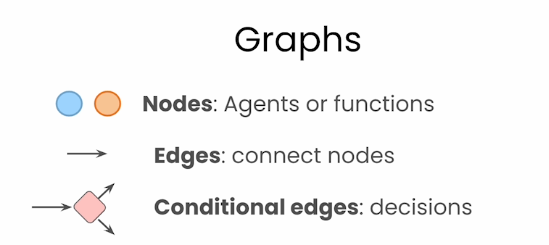

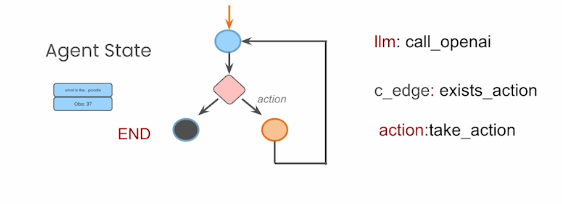

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [5]:
class Agent:

    #model to use, the tools to call, the system message
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

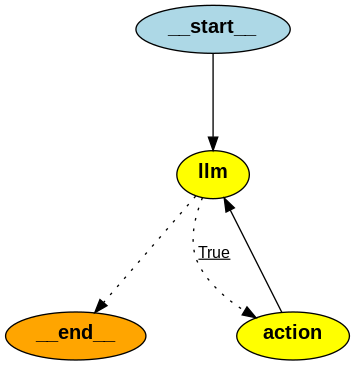

In [7]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [8]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX'}
Back to the model!


all the steps

In [9]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1007c7d9-5236-4d3b-949d-b2183b409159-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX'}]),
  ToolMessage(content='[{\'url\': \'https://weathershogun.com/weather/usa/ca/san-francisco/480/may/20

In [10]:
result['messages'][-1].content

'The weather in San Francisco today is cloudy with overcast skies. The temperature during the day is 66°F and at night it will be 52°F with a 25% chance of precipitation.'

In [13]:
messages = [HumanMessage(content="What is the weather in İzmir and Muğla?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in İzmir'}, 'id': 'call_ZG7mdUMhtsu5580a47KDx9pZ'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Muğla'}, 'id': 'call_XL1eY2EpomTOo8NB2u1NNmdj'}
Back to the model!


In [14]:
result['messages'][-1].content

"The current weather in İzmir is sunny with a temperature of 29.2°C. The wind speed is 20.9 km/h coming from the southwest direction. The humidity is at 31%, and there is no precipitation at the moment.\n\nIn Muğla, the weather in May is comfortable with temperatures ranging from 18°C to 23°C. There can be about 3 to 8 days of rain during the month, so it's advisable to have an umbrella handy."

In [15]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'call_HBUU1Lo9WSgKCPKYCAStSb7g'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_9BaNmmWXW7TSWiCks3TD1bXk'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri 2024'}, 'id': 'call_ueGOdbmYTgjadpekFkHfVOcS'}
Back to the model!


In [16]:
print(result['messages'][-1].content)

1. The Kansas City Chiefs won the Super Bowl in 2024.

2. The Kansas City Chiefs' headquarters is located in Kansas City, Missouri.

3. The GDP of Missouri in 2024 was approximately $455 billion, making it the 22nd-largest economy in the United States.


In [17]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the Eurovision song contest in 2024? And with which song? \
Where will be Eurovision 2025? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Eurovision Song Contest 2024 winner'}, 'id': 'call_kSy6kEPPCTzzw8IPYYSiONW0'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Eurovision Song Contest 2025 location'}, 'id': 'call_aaEGm2TXTdVFIr1ckhJCpxke'}
Back to the model!


In [18]:
print(result['messages'][-1].content)

1. The winner of the Eurovision Song Contest in 2024 was Switzerland, with the song "The Code" performed by Nemo.

2. The Eurovision Song Contest 2025 is set to take place in Basel, Switzerland.
